In [1]:
import random
import numpy as np
import pandas as pd
import time
import re
import datetime
import os
import matplotlib.pyplot as plt
# import gensim
# import spacy

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
# pip install bertopic

In [4]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
# # import stanza
# stanza.download('ru')      
# stanza.download('uk')      
# runlp = stanza.Pipeline('ru') 
# uknlp = stanza.Pipeline('uk')

In [6]:
# import stanza

In [7]:
# stanza.download('en')      
# nlp = stanza.Pipeline('en')

## Read data

In [8]:
df = pd.read_excel('Radcliffe Poetry Facebook Posts (Paige).xlsx',index_col=0)
# df = df[df['Language'].isin(['Ukrainian','Russian'])]
df.rename(columns = {'Poem full text (copy and paste)':'text'}, inplace = True)
print(len(df))
df.head()

1012


,Author of poem,Missing from Authors tab?,Author of post,Date posted,URL of facebook post,Private post or link not working?,Themes curated,Theme(s) (comma separated),Theme 2 (blank),Theme 3 (blank),...,Additional URL (if the post links to an external poem),fulltext,Comments (copy and paste),Number of likes,Number of comments,Number of shares,Other notes,Your name,Suggestion/correction in comment field?,Unnamed: 25
Timestamp,,,,,,,,,,,,,,,,,,,,,
87,Halyna Kruk,NaN,Halyna Kruk,2013-12-06,https://www.facebook.com/halyna.kruk/posts/101...,NaN,"{'maidan', 'revolution', 'protest', 'ukraine'}",Maidan,Ukraine,NaN,...,NaN,"9+\n3\n20+\nEran\nHalyna Kruk\nDecember 6, 201...",NaN,251.0,27.0,68.0,Read by author at Lviv Euromaidan,NaN,NaN,NaN
2022-04-10 23:30:07,Ostap Slyvynsky,NaN,Ostap Slyvynsky,2013-12-26,https://www.facebook.com/ostap.slyvynsky/posts...,NaN,"{'maidan', 'poetic form', 'haiku', 'revolution...","Haiku, Maidan",NaN,NaN,...,NaN,ХАЙКУ З МАЙДАНУ\nДим у рукавах.\nНіби йдеш з ц...,Yulia Tareieva\nТак як є\nSee Translation8y\nS...,93.0,7.0,10.0,NaN,Amelia Glaser,NaN,NaN
53,Osip Mandelstam,NaN,Maria Stepanova,2013-12-27,https://www.facebook.com/maria.stepanova.372,NaN,"{'time', 'war', 'twentieth century'}",war,twentieth century,NaN,...,NaN,9+\n3\n20+\nEran\nMaria Stepanova\n3 mutual\nA...,NaN,50.0,4.0,3.0,By Osip Mandelshtam (1935-36),NaN,NaN,NaN
2022-08-02 13:10:06.549000,Boris Khersonsky,NaN,Boris Khersonsky,2013-12-31,https://www.facebook.com/borkhers/posts/pfbid0...,NaN,NaN,"Soviet Union, food, morphine, anthem",NaN,NaN,...,NaN,NaN,Леонид Кучеренко\nЯ сразу вспомнил ТУ жизнь\n\...,120.0,19.0,11.0,NaN,Amelia Glaser,No,NaN
2022-04-29 11:28:58.828000,Oleksandr Irvanets,NaN,Oleksandr Irvanets,2014-01-01,https://www.facebook.com/alekirvan/posts/10202...,NaN,"{'seasons', 'time', 'new year'}",New year,NaN,NaN,...,NaN,NaN,"Lusienna Maselska\nПРЯМИЙ, ЯК КОЧЕРГА - БЛЄСК!...",111.0,7.0,4.0,NaN,Olga Kiyan,NaN,NaN


### Initialize documents

In [9]:
allrecords = df.to_dict('records')
records = [rec for rec in allrecords if rec['Language'] in ['Ukrainian','Russian']]
docs = [rec['text'] for rec in records]

In [10]:
poemDf = pd.DataFrame.from_records(records)

## Generate translated poems in English

In [15]:
# pip install spacy_fastlang

In [16]:
import spacy
import spacy_fastlang

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("language_detector")
doc = nlp('Life is like a box of chocolates. You never know what you are gonna get.')

doc._.language

'en'

In [17]:
from nltk.tokenize import sent_tokenize, word_tokenize
sent_tokenize('Life is like a box of chocolates. You never know what you are gonna get.')

['Life is like a box of chocolates.', 'You never know what you are gonna get.']

In [18]:
# https://pypi.org/project/translate-api/
# pip install translators --upgrade
import translators as ts

Using United States server backend.


In [21]:
%%time
def translate_text(text, langAbbrev):
    doc = nlp(text) 
    if not doc._.language in ['uk','ru']:
        return ''
    try:
        translatedText = ts.google(text, from_language=langAbbrev, to_language='en')
    except:
        halfIdx = len(text.split('\n'))//2
        firstHalf = '\n'.join(text.split('\n')[:halfIdx])
        secondHalf = '\n'.join(text.split('\n')[halfIdx:])
        try:
            transText1 = ts.google(firstHalf, from_language=langAbbrev, to_language='en')
            transText2 = ts.google(secondHalf, from_language=langAbbrev, to_language='en')
            translatedText = transText1 +'\n' + transText2
        except:
            translatedText = ts.google(text[:4000], from_language=langAbbrev, to_language='en')
            
    return translatedText

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 16 µs


In [55]:
%%time
line_sample = []
for i, rec in enumerate(records):
    if i in range(0,369):
        continue
    recTokens = []
    if i % 10 == 0:
        print(f'{i}/{len(records)} parsed.')
        if line_sample != []:
            print(random.choice(random.choice(line_sample)))
    langAbbrev = rec['Language'].lower()[:2]
    lines = rec['text'].split('\n')
    linesInPoem = []
    for line in lines:
        if len(line) > 100:
            # split line by sentence
            sentlines = sent_tokenize(line)
            for newline in sentlines:
                enLine = translate_text(newline, langAbbrev)
                linesInPoem.append({
                    'original' : newline,
                    'en' : enLine
                })
        else:
            enLine = translate_text(line, langAbbrev)
            linesInPoem.append({
                'original' : line,
                'en' : enLine
             })
            
    rec['translatedLines'] = linesInPoem
    line_sample.append(linesInPoem)

370/926 parsed.
{'original': 'Jeśli wysłałeś sobie list łykami.', 'en': ''}
380/926 parsed.
{'original': 'ледве дихає ', 'en': 'Barely breathes'}
390/926 parsed.
{'original': 'Погладжуючи живіт, у якім слово, що було спочатку.', 'en': 'Stroking the abdomen, in which the word that was originally.'}
400/926 parsed.
{'original': 'і зелені огірки дітей', 'en': 'and green cucumbers of children'}
410/926 parsed.
{'original': 'Схилявся день до західної брами ', 'en': 'Leaning day to the Western Gate'}
420/926 parsed.
{'original': 'стільки ниток заплетено у канат', 'en': 'so many threads are braided into a rope'}
430/926 parsed.
{'original': 'зималето', 'en': ''}
440/926 parsed.
{'original': 'Я хочу тебе відвести під краплак', 'en': 'I want to take you under a lap'}
450/926 parsed.
{'original': 'Добре, добре, знищуй листи,', 'en': 'Well, well, destroy the letters,'}
460/926 parsed.
{'original': 'стирай номери, пали мости,', 'en': 'ripen numbers, fuel bridges,'}
470/926 parsed.
{'original': 'Ін

In [56]:
records[369]['translatedLines']

[{'original': 'За вчора і сьогодні - кілька добрих новин:',
  'en': 'For yesterday and today - a few good news:'},
 {'original': '1. Зробила спробу написати хокку під впливом Maya Studzinskaya, а темою завдячую Olaf Clemensen',
  'en': '1. I attempted to write a hokku under the influence of Maya Studzinskaya, and the topic is olaf clamesen'},
 {'original': '* * *', 'en': ''},
 {'original': 'місячна ніч', 'en': 'monthly night'},
 {'original': 'мати дістала прикраси', 'en': 'The mother got jewelry'},
 {'original': 'час незворотній', 'en': 'Time is irreversible'},
 {'original': '* * *', 'en': ''},
 {'original': 'на шиї кольє', 'en': 'On the neck of the necklace'},
 {'original': 'пригадують руки', 'en': 'Remember their hands'},
 {'original': 'важкість перснів', 'en': 'The severity of the rings'},
 {'original': '* * *', 'en': ''},
 {'original': 'візерунки осені', 'en': 'Autumn patterns'},
 {'original': 'від камеї в долоні',
  'en': 'from the cameo in the palm of your hand'},
 {'original': '

In [58]:
# recsWT = pd.DataFrame.from_records(records)
# recsWT.to_excel('recsEnglishTranslationWithLINES_9-2.xlsx')

## Bert Topic Modeling

In [28]:
# pip install stopwordsiso

In [8]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [9]:
import stopwordsiso as stopwords
# russian, ukrainian, and english
iso_stopwords = list(stopwords.stopwords(["ru","uk","en"]))
ukstops = ['а', 'аби', 'абиде', 'абиким', 'абикого', 'абиколи', 'абикому', 'абикуди', 'абихто', 'абичий', 'абичийого', 'абичийому', 'абичим', 'абичию', 'абичия', 'абичиє', 'абичиєму', 'абичиєю', 'абичиєї', 'абичиї', 'абичиїй', 'абичиїм', 'абичиїми', 'абичиїх', 'абичого', 'абичому', 'абищо', 'абияка', 'абияке', 'абиякий', 'абияким', 'абиякими', 'абияких', 'абиякого', 'абиякому', 'абиякою', 'абиякої', 'абияку', 'абиякі', 'абиякій', 'абиякім', 'або', 'абощо', 'авжеж', 'авось', 'ага', 'ад', 'адже', 'аж', 'ажень', 'аз', 'ай', 'але', 'ало', 'амінь', 'ант', 'ану', 'ані', 'аніде', 'аніж', 'анізащо', 'аніким', 'анікого', 'анікогісінько', 'аніколи', 'анікому', 'аніскільки', 'аніхто', 'анічим', 'анічого', 'анічогісінько', 'анічому', 'аніщо', 'аніяка', 'аніяке', 'аніякий', 'аніяким', 'аніякими', 'аніяких', 'аніякого', 'аніякому', 'аніякою', 'аніякої', 'аніяку', 'аніякі', 'аніякій', 'аніякім', 'аніякісенька', 'аніякісеньке', 'аніякісенький', 'аніякісеньким', 'аніякісенькими', 'аніякісеньких', 'аніякісенького', 'аніякісенькому', 'аніякісенькою', 'аніякісенької', 'аніякісеньку', 'аніякісенькі', 'аніякісенькій', 'аніякісенькім', 'аніякісінька', 'аніякісіньке', 'аніякісінький', 'аніякісіньким', 'аніякісінькими', 'аніякісіньких', 'аніякісінького', 'аніякісінькому', 'аніякісінькою', 'аніякісінької', 'аніякісіньку', 'аніякісінькі', 'аніякісінькій', 'аніякісінькім', 'ат', 'ато', 'атож', 'ау', 'ах', 'ач', 'ачей', 'аякже', 'б', 'ба', 'багато', 'багатьма', 'багатьом', 'багатьох', 'баз', 'бай', 'бат', 'бах', 'бац', 'баш', 'бе', 'беж', 'без', 'безперервно', 'бел', 'бер', 'би', 'бир', 'бич', 'близько', 'близько від', 'бо', 'бов', 'бод', 'бодай', 'боз', 'бош', 'був', 'буває', 'буде', 'будем', 'будемо', 'будете', 'будеш', 'буду', 'будуть', 'будь', 'будь ласка', 'будьмо', 'будьте', 'була', 'були', 'було', 'бути', 'бух', 'буц', 'буцім', 'буцімто', 'бі', 'біб', 'більш', 'більше', 'біля', 'в', 'в бік', 'в залежності від', 'в міру', 'в напрямі до', 'в порівнянні з', 'в процесі', 'в результаті', 'в ролі', 'в силу', 'в сторону', 'в супроводі', 'в ході', "в ім'я", 'в інтересах', 'вад', 'важлива', 'важливе', 'важливий', 'важливі', 'вак', 'вам', 'вами', 'ван', 'вас', 'ват', 'ваш', 'ваша', 'ваше', 'вашим', 'вашими', 'ваших', 'вашого', 'вашому', 'вашою', 'вашої', 'вашу', 'ваші', 'вашій', 'вашім', 'ввесь', 'вві', 'вгору', 'вдалині', 'вед', 'верх', 'весь', 'вех', 'вже', 'вздовж', 'ви', 'виз', 'вис', 'височині', 'вище ', 'вйо', 'власне', 'властиво', 'вміти', 'внаслідок', 'вниз', 'внизу', 'во', 'вон', 'вона', 'вони', 'воно', 'восьмий', 'вперед', 'вподовж', 'впоперек', 'впритиск', 'впритул', 'впродовж', 'впрост', 'все', 'всередині', 'всею', 'вслід', 'всупереч', 'всього', 'всьому', 'всю', 'всюди', 'вся', 'всяк', 'всяка', 'всяке', 'всякий', 'всяким', 'всякими', 'всяких', 'всякого', 'всякому', 'всякою', 'всякої', 'всяку', 'всякі', 'всякій', 'всякім', 'всі', 'всій', 'всіляка', 'всіляке', 'всілякий', 'всіляким', 'всілякими', 'всіляких', 'всілякого', 'всілякому', 'всілякою', 'всілякої', 'всіляку', 'всілякі', 'всілякій', 'всілякім', 'всім', 'всіма', 'всіх', 'всією', 'всієї', 'втім', 'ві', 'віг', 'від', 'від імені', 'віддалік від', 'відколи', 'відносно', 'відповідно', 'відповідно до', 'відсотків', 'відтепер', 'відтоді', 'він', 'вісім', 'вісімнадцятий', 'вісімнадцять', 'віт', 'віф', 'віх', 'віц', 'віщо', 'віщось', 'г', 'га', 'гав', 'гаразд', 'ге', 'гез', 'гем', 'геп', 'гет', 'геть', 'гех', 'ги', 'гик', 'гир', 'гич', 'гм', 'го', 'говорив', 'гог', 'гоп', 'гоц', 'гу', 'гуп', 'д', 'да', 'давай', 'давати', 'давно', 'далеко', 'далеко від', 'далі', 'даром', 'два', 'двадцятий', 'двадцять', 'дванадцятий', 'дванадцять', 'двох', 'дві', 'де', "дев'ятий", "дев'ятнадцятий", "дев'ятнадцять", "дев'ять", 'дедалі', 'деким', 'декого', 'деколи', 'декому', 'декотра', 'декотре', 'декотрий', 'декотрим', 'декотрими', 'декотрих', 'декотрого', 'декотрому', 'декотрою', 'декотрої', 'декотру', 'декотрі', 'декотрій', 'декотрім', 'декілька', 'декільком', 'декількома', 'декількох', 'декім', 'десь', 'десятий', 'десять', 'дехто', 'дечий', 'дечийого', 'дечийому', 'дечим', 'дечию', 'дечия', 'дечиє', 'дечиєму', 'дечиєю', 'дечиєї', 'дечиї', 'дечиїй', 'дечиїм', 'дечиїми', 'дечиїх', 'дечого', 'дечому', 'дечім', 'дещо', 'деяка', 'деяке', 'деякий', 'деяким', 'деякими', 'деяких', 'деякого', 'деякому', 'деякою', 'деякої', 'деяку', 'деякі', 'деякій', 'деякім', 'деінде', 'для', 'до', 'добре', 'довго', 'довкола', 'довкіл', 'дог', 'доки', 'допоки', 'допіру', 'досить', 'досі', 'дотепер', 'доти', 'другий', 'друго', 'дуже', 'дякую', 'дійсно', 'діл', 'е', 'еге', 'еж', 'ей', 'ерг', 'ест', 'ет', 'ех', 'еч', 'ж', 'же', 'жоден', 'жодна', 'жодне', 'жодний', 'жодним', 'жодними', 'жодних', 'жодного', 'жодному', 'жодною', 'жодної', 'жодну', 'жодні', 'жодній', 'жоднім', 'жоднісінька', 'жоднісіньке', 'жоднісінький', 'жоднісіньким', 'жоднісінькими', 'жоднісіньких', 'жоднісінького', 'жоднісінькому', 'жоднісінькою', 'жоднісінької', 'жоднісіньку', 'жоднісінькі', 'жоднісінькій', 'жоднісінькім', 'жуз', 'з', 'з метою', 'з нагоди', 'з приводу', 'з розрахунку на', 'з-за', 'з-над', 'з-перед', 'з-поза', 'з-поміж', 'з-понад', 'з-поперед', 'з-посеред', 'з-проміж', 'з-під', 'з-серед', 'за', 'за винятком', 'за допомогою', 'за посередництвом', 'за рахунок', 'завгодно', 'завдяки', 'завжди', 'завше', 'задля', 'зазвичай', 'зайнята', 'зайнятий', 'зайнято', 'зайняті', 'залежно', 'залежно від', 'замість', 'занадто', 'заради', 'зараз', 'зас', 'зате', 'збоку', 'збоку від', 'зважаючи на', 'зверх ', 'зверху', 'звичайно', 'звиш', 'звідки', 'звідкилясь', 'звідкись', 'звідкіль', 'звідкіля', 'звідкілясь', 'звідси', 'звідсіль', 'звідсіля', 'звідти', 'звідтіль', 'звідтіля', 'звідусюди', 'звідусіль', 'звідціля', 'згідно з', 'здається', 'здовж', 'зем', 'зет', 'ззаду', 'зиз', 'зик', 'значить', 'знову', 'зо', 'зовсім', 'зсередини', 'зух', 'зі', 'зіс', 'и', 'ич', 'й', 'ймовірно', 'йно', 'йо', 'його', 'йой', 'йол', 'йому', 'йор', 'йот', 'йох', 'к', 'каже', 'каз', 'кар', 'каф', 'ках', 'ке', 'кед', 'кет', 'кеш', 'кив', 'кий', 'кил', 'ким', 'кимось', 'кимсь', 'ких', 'киш', 'коб', 'коби', 'кого', 'когось', 'кожен', 'кожна', 'кожне', 'кожний', 'кожним', 'кожними', 'кожних', 'кожного', 'кожному', 'кожною', 'кожної', 'кожну', 'кожні', 'кожній', 'кожнім', 'кожнісінька', 'кожнісіньке', 'кожнісінький', 'кожнісіньким', 'кожнісінькими', 'кожнісіньких', 'кожнісінького', 'кожнісінькому', 'кожнісінькою', 'кожнісінької', 'кожнісіньку', 'кожнісінькі', 'кожнісінькій', 'кожнісінькім', 'коли', 'колись', 'коло', 'кому', 'комусь', 'котра', 'котрась', 'котре', 'котресь', 'котрий', 'котрийсь', 'котрим', 'котрими', 'котримись', 'котримось', 'котримсь', 'котрих', 'котрихось', 'котрихсь', 'котрого', 'котрогось', 'котрому', 'котромусь', 'котрою', 'котроюсь', 'котрої', 'котроїсь', 'котру', 'котрусь', 'котрі', 'котрій', 'котрійсь', 'котрім', 'котрімсь', 'котрісь', 'коц', 'коч', 'коштом', 'край', 'краще', 'кру', 'круг', 'кругом', 'крю', 'кря', 'крізь', 'крім', 'куди', 'кудись', 'кудою', 'кілька', 'кільком', 'кількома', 'кількох', 'кім', 'кімось', 'кімсь', 'кінець', 'л', 'лаж', 'лап', 'лас', 'лат', 'ле', 'ледве', 'ледь', 'лет', 'лиш', 'лише', 'лишень', 'лум', 'луп', 'лут', 'льє', 'люди', 'людина', 'ля', 'лі', 'ліворуч від', 'лік', 'лім', 'м', 'мабуть', 'майже', 'мало', 'мати', 'мац', 'ме', 'меж', 'мене', 'менше', 'мені', 'мерсі', 'мет', 'мжа', 'ми', 'мимо ', 'миру', 'мит', 'мною', 'мо', 'мов', 'мовби', 'мовбито', 'могла', 'могли', 'могло', 'мого', 'могти', 'мож', 'може', 'можем', 'можемо', 'можете', 'можеш', 'можна', 'можу', 'можуть', 'можіть', 'мой', 'мол', 'мою', 'моя', 'моє', 'моєму', 'моєю', 'моєї', 'мої', 'моїй', 'моїм', 'моїми', 'моїх', 'му', 'мі', 'міг', 'між', 'мій', 'мільйонів', 'н', 'на', 'на адресу', 'на базі', 'на благо', 'на випадок', 'на відміну від', 'на засадах', 'на знак', 'на зразок', 'на користь', 'на кшталт', 'на межі', 'на основі', 'на противагу', 'на підставі', 'на честь', 'на чолі', 'на ґрунті', 'навколо', 'навкруг', 'навкруги ', 'навкіл', 'навпаки', 'навперейми', 'навпроти', 'навіть', 'навіщо', 'навіщось', 'нагорі', 'над', 'надо', 'надовкола', 'надокола', 'наді', 'назавжди', 'назад', 'назустріч', 'най', 'найбільш', 'нам', 'нами', 'наоколо ', 'наокруг ', 'наокруги ', 'наокіл', 'наперед', 'напередодні', 'напереді', 'наперекір', 'напереріз', 'наприкінці', 'напроти', 'нарешті', 'нарівні з', 'нас', 'насеред', 'насподі', 'наспід', 'настрічу', 'насупроти', 'насупротив ', 'нате', 'наче', 'начеб', 'начебто', 'наш', 'наша', 'наше', 'нашим', 'нашими', 'наших', 'нашого', 'нашому', 'нашою', 'нашої', 'нашу', 'наші', 'нашій', 'нашім', 'не', 'не до', 'не можна', 'неабичим', 'неабичого', 'неабичому', 'неабищо', 'небагато', 'небагатьма', 'небагатьом', 'небагатьох', 'небудь', 'невважаючи', 'невже', 'недалеко', 'недалеко від', 'неж', 'незалежно від', 'незважаючи', 'незважаючи на', 'ней', 'немає', 'немов', 'немовби', 'немовбито', 'неначе', 'неначебто', 'неподалеку', 'неподалеку від', 'неподалечку', 'неподалечку від', 'неподалік', 'неподалік від', 'нерідко', 'нех', 'нехай', 'нещодавно', 'нею', 'неї', 'нижче', 'низько', 'ник', 'ним', 'ними', 'них', 'нич', 'но', 'ну', 'нуг', 'нуд', 'нум', 'нумо', 'нумте', 'ньо', 'нього', 'ньому', 'ню', 'нюх', 'ня', 'няв', 'ні', 'ніби', 'ніби-то', 'нібито', 'ніде', 'ніж', 'нізащо', 'нізвідки', 'нізвідкіля', 'ній', 'ніким', 'нікого', 'нікогісінько', 'ніколи', 'нікому', 'нікотра', 'нікотре', 'нікотрий', 'нікотрим', 'нікотрими', 'нікотрих', 'нікотрого', 'нікотрому', 'нікотрою', 'нікотрої', 'нікотру', 'нікотрі', 'нікотрій', 'нікотрім', 'нікуди', 'нім', 'нінащо', 'ніскільки', 'ніт', 'ніхто', 'нічий', 'нічийна', 'нічийне', 'нічийний', 'нічийним', 'нічийними', 'нічийних', 'нічийного', 'нічийному', 'нічийною', 'нічийної', 'нічийну', 'нічийні', 'нічийній', 'нічийнім', 'нічийого', 'нічийому', 'нічим', 'нічию', 'нічия', 'нічиє', 'нічиєму', 'нічиєю', 'нічиєї', 'нічиї', 'нічиїй', 'нічиїм', 'нічиїми', 'нічиїх', 'нічого', 'нічому', 'ніщо', 'ніяк', 'ніяка', 'ніяке', 'ніякий', 'ніяким', 'ніякими', 'ніяких', 'ніякого', 'ніякому', 'ніякою', 'ніякої', 'ніяку', 'ніякі', 'ніякій', 'ніякім', 'ніякісінька', 'ніякісіньке', 'ніякісінький', 'ніякісіньким', 'ніякісінькими', 'ніякісіньких', 'ніякісінького', 'ніякісінькому', 'ніякісінькою', 'ніякісінької', 'ніякісіньку', 'ніякісінькі', 'ніякісінькій', 'ніякісінькім', 'о', 'об', 'обабіч', 'обаполи', 'обидва', 'обр', 'обік', 'обіруч', 'обіч', 'ов', 'од', 'один', 'одинадцятий', 'одинадцять', 'одна', 'однак', 'одначе', 'одне', 'одним', 'одними', 'одних', 'одно', 'одного', 'одного разу', 'одному', 'одною', 'одної', 'одну', 'одні', 'одній', 'однім', 'однією', 'однієї', 'ож', 'ой', 'окрай', 'окроме', 'округ', 'округи', 'окрім', 'окіл', 'ом', 'он', 'онде', 'онно', 'оно', 'оподаль', 'оподаль від', 'оподалік', 'оподалік від', 'опостін', 'опостінь', 'опроче', 'опріч', 'опріче', 'опісля', 'осе', 'оскільки', 'особливо', 'осторонь', 'ось', 'осісьо', 'от', 'ота', 'отак', 'отака', 'отаке', 'отакий', 'отаким', 'отакими', 'отаких', 'отакого', 'отакому', 'отакою', 'отакої', 'отаку', 'отакі', 'отакій', 'отакім', 'отакісінька', 'отакісіньке', 'отакісінький', 'отакісіньким', 'отакісінькими', 'отакісіньких', 'отакісінького', 'отакісінькому', 'отакісінькою', 'отакісінької', 'отакісіньку', 'отакісінькі', 'отакісінькій', 'отакісінькім', 'отам', 'оте', 'отже', 'отим', 'отими', 'отих', 'ото', 'отого', 'отож', 'отой', 'отому', 'отою', 'отої', 'отсе', 'оттак', 'отто', 'оту', 'отут', 'оті', 'отій', 'отім', 'отією', 'отієї', 'ох', 'оце', 'оцей', 'оцим', 'оцими', 'оцих', 'оцього', 'оцьому', 'оцю', 'оця', 'оці', 'оцій', 'оцім', 'оцією', 'оцієї', 'п', "п'я", "п'ятий", "п'ятнадцятий", "п'ятнадцять", "п'ять", 'па', 'пад', 'пак', 'пек', 'перед', 'передо', 'переді', 'перетака', 'перетаке', 'перетакий', 'перетаким', 'перетакими', 'перетаких', 'перетакого', 'перетакому', 'перетакою', 'перетакої', 'перетаку', 'перетакі', 'перетакій', 'перетакім', 'перший', 'пиж', 'плі', 'по', 'поблизу', 'побік', 'побіля', 'побіч', 'поверх', 'повз', 'повздовж', 'повинно', 'повище', 'повсюди', 'повсюдно', 'подаль від', 'подалі від', 'подекуди', 'подеяка', 'подеяке', 'подеякий', 'подеяким', 'подеякими', 'подеяких', 'подеякого', 'подеякому', 'подеякою', 'подеякої', 'подеяку', 'подеякі', 'подеякій', 'подеякім', 'подовж', 'подібно до', 'поз', 'поза', 'позад', 'позаду', 'позата', 'позате', 'позатим', 'позатими', 'позатих', 'позатого', 'позатой', 'позатому', 'позатою', 'позатої', 'позату', 'позаті', 'позатій', 'позатім', 'позатією', 'позатієї', 'позаяк', 'поздовж', 'поки', 'покрай', 'покіль', 'помежи', 'помимо', 'поміж', 'помість', 'понад', 'понадо', 'понаді', 'понижче', 'пообіч', 'поодаль від', 'поодалік від', 'поперед', 'попереду', 'поперек', 'попліч', 'попри', 'попросту', 'попід', 'пора', 'поруч', 'поряд', 'поряд з', 'порівняно з', 'посеред', 'посередині', 'потрібно', 'потім', 'поуз', 'початку', 'почерез', 'праворуч від', 'пред', 'предо', 'преді', 'прекрасно', 'прецінь', 'при', 'притому', 'причому', 'причім', 'про', 'проз', 'промеж', 'проміж', 'просто', 'проте', 'проти', 'против', 'противно', 'протягом', 'пря', 'пріч', 'пхе', 'пху', 'пі', 'пів', 'півперек', 'під', 'під знаком', 'під приводом', 'під час', 'підо', 'пізніше', 'пім', 'пір', 'після', 'р', 'ради', 'раз', 'разом з', 'разу', 'рано', 'раніш', 'раніш від', 'раніше', 'раніше від', 'раптом', 'ре', 'рет', 'риж', 'рим', 'рип', 'роб', 'року', 'років', 'рос', 'рох', 'році', 'рус', 'рух', 'руч', 'рік', 'с', 'саж', 'саз', 'сак', 'сам', 'сама', 'саме', 'сами', 'самий', 'самим', 'самими', 'самих', 'само', 'самого', 'самому', 'самою', 'самої', 'саму', 'самі', 'самій', 'самім', 'сап', 'сас', 'свого', 'свою', 'своя', 'своє', 'своєму', 'своєю', 'своєї', 'свої', 'своїй', 'своїм', 'своїми', 'своїх', 'свій', 'се', 'себе', 'себто', 'сей', 'сен', 'серед', 'середи', 'середу', 'сеч', 'си', 'сив', 'сиг', 'сиз', 'сик', 'сиріч', 'сих', 'сказав', 'сказала', 'сказати', 'скрізь', 'скільки', 'скільки-то', 'скількись', 'скільком', 'скількома', 'скількомась', 'скількомось', 'скількомсь', 'скількох', 'скількохось', 'скількохсь', 'сли', 'слідом за', 'соб', 'собою', 'собі', 'соп', 'спасибі', 'спереду', 'спочатку', 'справ', 'справді', 'став', 'стосовно', 'стільки', 'стільком', 'стількома', 'стількох', 'су', 'судячи з', 'супроти', 'супротив', 'суть', 'суч', 'суш', 'сьогодні', 'сьомий', 'сюди', 'ся', 'сяг', 'сяк', 'сяка', 'сяке', 'сякий', 'сяким', 'сякими', 'сяких', 'сякого', 'сякому', 'сякою', 'сякої', 'сяку', 'сякі', 'сякій', 'сякім', 'сям', 'сі', 'сім', 'сімнадцятий', 'сімнадцять', 'сіп', 'т', 'та', 'таж', 'так', 'така', 'таке', 'такенна', 'такенне', 'такенний', 'такенним', 'такенними', 'такенних', 'такенного', 'такенному', 'такенною', 'такенної', 'такенну', 'такенні', 'такенній', 'такеннім', 'таки', 'такий', 'таким', 'такими', 'таких', 'такого', 'також', 'такому', 'такою', 'такої', 'таку', 'такі', 'такій', 'такім', 'такісінька', 'такісіньке', 'такісінький', 'такісіньким', 'такісінькими', 'такісіньких', 'такісінького', 'такісінькому', 'такісінькою', 'такісінької', 'такісіньку', 'такісінькі', 'такісінькій', 'такісінькім', 'тал', 'там', 'тамки', 'тамта', 'тамте', 'тамтим', 'тамтими', 'тамтих', 'тамтого', 'тамтой', 'тамтому', 'тамтою', 'тамтої', 'тамту', 'тамті', 'тамтій', 'тамтім', 'тамтією', 'тамтієї', 'тар', 'тат', 'таш', 'тва', 'твого', 'твою', 'твоя', 'твоє', 'твоєму', 'твоєю', 'твоєї', 'твої', 'твоїй', 'твоїм', 'твоїми', 'твоїх', 'твій', 'те', 'тебе', 'тег', 'теж', 'тем', 'тепер', 'теперечки', 'тес', 'теф', 'теє', 'ти', 'тик', 'тил', 'тим', 'тими', 'тисяч', 'тих', 'то', 'тобою', 'тобто', 'тобі', 'того', 'тоді', 'тож', 'той', 'тол', 'тому', 'тому що', 'тот', 'тощо', 'тою', 'тої', 'тра', 'тре', 'треба', 'третій', 'три', 'тринадцятий', 'тринадцять', 'трохи', 'тс', 'тсс', 'ту', 'туди', 'тудою', 'туп', 'тут', 'тутеньки', 'тутечки', 'тутки', 'туф', 'туц', 'тю', 'тюг', 'тюп', 'тяг', 'тяж', 'тям', 'тяп', 'ті', 'тій', 'тільки', 'тім', 'тією', 'у', 'у бік', 'у вигляді', 'у випадку', 'у відповідності до', 'у відповідь на', 'у залежності від', "у зв'язку з", 'у міру', 'у напрямі до', 'у порівнянні з', 'у процесі', 'у результаті', 'у ролі', 'у силу', 'у сторону', 'у супроводі', 'у ході', 'ув', 'увесь', 'уві', 'угу', 'уже', 'узбіч', 'уздовж', 'укр', 'ум', 'унаслідок', 'униз', 'унизу', 'унт', 'уперед', 'уподовж', 'упоперек', 'упритиск до', 'упритул до', 'упродовж', 'упрост', 'ус', 'усе', 'усередині', 'услід', 'услід за', 'усупереч', 'усього', 'усьому', 'усю', 'усюди', 'уся', 'усяк', 'усяка', 'усяке', 'усякий', 'усяким', 'усякими', 'усяких', 'усякого', 'усякому', 'усякою', 'усякої', 'усяку', 'усякі', 'усякій', 'усякім', 'усі', 'усій', 'усіляка', 'усіляке', 'усілякий', 'усіляким', 'усілякими', 'усіляких', 'усілякого', 'усілякому', 'усілякою', 'усілякої', 'усіляку', 'усілякі', 'усілякій', 'усілякім', 'усім', 'усіма', 'усіх', 'усією', 'усієї', 'утім', 'ух', 'ф', "ф'ю", 'фа', 'фаг', 'фай', 'фат', 'фе', 'фед', 'фез', 'фес', 'фет', 'фзн', 'фоб', 'фот', 'фра', 'фру', 'фу', 'фук', 'фур', 'фус', 'фіш', 'х', 'ха', 'хаз', 'хай', 'хап', 'хат', 'хащ', 'хе', 'хет', 'хи', 'хиб', 'хм', 'хо', 'хов', 'хол', 'хон', 'хоп', 'хор', 'хотіти', 'хоч', 'хоча', 'хочеш', 'хро', 'хрю', 'хто', 'хтось', 'ху', 'хуз', 'хук', 'хух', 'хху', 'хіба', 'ц', 'це', 'цебто', 'цей', 'цеп', 'ци', 'цим', 'цими', 'цир', 'цих', 'цло', 'цоб', 'цок', 'цоп', 'цор', 'цс', 'цсс', 'цуг', 'цур', 'цуц', 'цього', 'цьому', 'цю', 'цюк', 'ця', 'цяв', 'цяп', 'ці', 'цід', 'цій', 'цім', 'ціною', 'цією', 'цієї', 'ч', 'чал', 'чар', 'час', 'часто', 'частіше', 'часу', 'чах', 'чей', 'чень', 'через', 'четвертий', 'чи', 'чий', 'чийого', 'чийогось', 'чийому', 'чийомусь', 'чийсь', 'чик', 'чим', 'чимось', 'чимсь', 'чир', 'численна', 'численне', 'численний', 'численним', 'численними', 'численних', 'численні', 'чию', 'чиюсь', 'чия', 'чиясь', 'чиє', 'чиєму', 'чиємусь', 'чиєсь', 'чиєю', 'чиєюсь', 'чиєї', 'чиєїсь', 'чиї', 'чиїй', 'чиїйсь', 'чиїм', 'чиїми', 'чиїмись', 'чиїмось', 'чиїмсь', 'чиїсь', 'чиїх', 'чиїхось', 'чиїхсь', 'чля', 'чого', 'чогось', 'чом', 'чому', 'чомусь', 'чон', 'чоп', 'чортзна', 'чос', 'чотири', 'чотирнадцятий', 'чотирнадцять', 'чу', 'чум', 'чур', 'чш', 'чім', 'чімось', 'чімсь', 'чіт', 'ш', 'ша', 'шаг', 'шал', 'шам', 'шво', 'шед', 'шен', 'шиз', 'шир', 'шляхом', 'шостий', 'шістнадцятий', 'шістнадцять', 'шість', 'щ', 'ще', 'щем', 'щеп', 'щип', 'щир', 'що', 'щоб', 'щоби', 'щодо', 'щойно', 'щоправда', 'щось', 'щі', 'ь', 'ю', 'юз', 'юн', 'юнь', 'юс', 'ют', 'юхт', 'я', 'яв', 'яд', 'яз', 'язь', 'як', 'яка', 'якась', 'якби', 'яке', 'якесь', 'який', 'якийсь', 'яким', 'якими', 'якимись', 'якимось', 'якимсь', 'яких', 'якихось', 'якихсь', 'якого', 'якогось', 'якому', 'якомусь', 'якось', 'якою', 'якоюсь', 'якої', 'якоїсь', 'якраз', 'яку', 'якусь', 'якщо', 'які', 'якій', 'якійсь', 'якім', 'якімсь', 'якісь', 'ял', 'ям', 'ян', 'янь', 'яо', 'яп', 'ярл', 'ясь', 'ять', 'є', 'єр', 'єси', 'і', 'ібн', 'ід', 'із', 'із-за', 'із-під', 'іззаду', 'ізм', 'ізсередини', 'ік', 'ікс', 'ікт', "ім'я", 'імовірно', 'інакша', 'інакше', 'інакший', 'інакшим', 'інакшими', 'інакших', 'інакшого', 'інакшому', 'інакшою', 'інакшої', 'інакшу', 'інакші', 'інакшій', 'інакшім', 'інколи', 'іноді', 'інша', 'інше', 'інший', 'іншим', 'іншими', 'інших', 'іншого', 'іншому', 'іншою', 'іншої', 'іншу', 'інші', 'іншій', 'іншім', 'інь', 'іч', 'іще', 'ї', 'їдь', 'їй', 'їм', 'їх', 'їхнього', 'їхньому', 'їхньою', 'їхньої', 'їхню', 'їхня', 'їхнє', 'їхні', 'їхній', 'їхнім', 'їхніми', 'їхніх', 'її', 'ґ']
all_stops = iso_stopwords + ukstops
stops_and_punct = list(string.punctuation) + all_stops

In [59]:
df = pd.read_excel('recsEnglishTranslationWithLINES_9-2.xlsx',index_col=0)
records = df.to_dict('records')
print(random.choice(records)['translatedLines'])

[{'original': 'Конец света (сон)', 'en': 'The end of the world (sleep)'}, {'original': 'В сентябре в Коктебеле, накрытом страшной чернильной тучей,', 'en': 'In September in Koktebel, covered with a terrible ink cloud,'}, {'original': 'мне приснились шаги человека, который страдал падучей.', 'en': 'I dreamed about the steps of the man who suffered from Paduchi.'}, {'original': 'Он пытался уйти от берега, на губах – красная пена.', 'en': 'He tried to leave the shore, and red foam on his lips.'}, {'original': 'На языке глухонемых кричал, изображая геенну', 'en': 'In the language of the deaf -mute screaming, portraying Geenna'}, {'original': 'огненную. Я подумала, не запастись ли горем.', 'en': 'Fiery. I thought if you were wise.'}, {'original': 'Но пошла большая вода. Хлынула горлом, небом, морем.', 'en': 'But big water went. She poured with her throat, heaven, sea.'}, {'original': 'Я увидела горизонт без линии с красной рваной дырою.', 'en': 'I saw a horizon without a line with a red tor

#### get author names

In [41]:
nameSet = set()
for rec in records:
    author1 = rec['Author of post']
    if not isinstance(author1, str):
        author1 = ''
    author2 = rec['Author of poem']
    if not isinstance(author2, str):
        author2 = ''
    names = author1.split(' ') + author2.split(' ')
    for n in names:
        if n.isalpha():
            nameSet.add(n.lower())

In [42]:
len(nameSet)

222

#### Tokenizer

In [11]:
# import these modules
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()

In [16]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')

In [120]:
print(sample_text)

though whispers, though by crying, though by howling 
 the soul is looking for words - not enough 
 When the Teresa of Human Life 
 What makes sense and what loses it? 

 everyone you have not saved now, 
 kiss in light eyes finally 
 Black snow fell on a black city 
 and on the eyelids of white did not melt 

 and though this night is a sticky like a resin 
 and no mask hides evil 
 and a shingle enters treacherously and subcutaneously


### practice processing

In [119]:
# practice tokenizing and lemmatizing
sample_text = '''though whispers, though by crying, though by howling \n the soul is looking for words - not enough \n When the Teresa of Human Life \n What makes sense and what loses it? \n\n everyone you have not saved now, \n kiss in light eyes finally \n Black snow fell on a black city \n and on the eyelids of white did not melt \n\n and though this night is a sticky like a resin \n and no mask hides evil \n and a shingle enters treacherously and subcutaneously'''
tokenized_text = [w for w in word_tokenize(sample_text) if w not in stops_and_punct]
lemmatized_tokens = [lemmatizer.lemmatize(t).lower() for t in tokenized_text]
lemmatized_tokens[:10]

['whisper',
 'cry',
 'howling',
 'soul',
 'when',
 'teresa',
 'human',
 'life',
 'what',
 'sense']

In [54]:
# def nlp_tokenizer(string):
#     tokens = []
#     parsedText = nlp(string)
#     for token in parsedText.iter_words():
#         if token.text.lower() in all_stops:
#             continue
#         if token.text.isalpha():
#             tokens.append(token.lemma.lower())
#     return tokens

def tokenizer(text):
    tokenized_text = [w for w in word_tokenize(text) if w not in stops_and_punct]
    lemmatized_tokens = [lemmatizer.lemmatize(t).lower() for t in tokenized_text]
    not_authors = [l for l in lemmatized_tokens if l not in nameSet]
    tokens = [n for n in not_authors if n.isalpha()]
    return tokens

### BERT model

In [106]:
doc_lines = [rec['translatedLines'] for rec in records]
        
doc_sample = []
line2rec = dict()
lineIdx = 0
for i, doc in enumerate(doc_lines):
    for line in doc:
        doc_sample.append(line['en'].strip())
        lineIdx += 1
        line2rec[lineIdx] = i

In [108]:
print(doc_sample[1009])
recIdx = line2rec[1000]
records[recIdx]

'The house was passed by the beasts, to the live flesh of the cure,'

In [64]:
%%time

sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(doc_sample, show_progress_bar=True)
vectorizer_model = CountVectorizer(ngram_range=(1, 1),lowercase=False,tokenizer=tokenizer)

Batches: 100%|██████████| 656/656 [06:00<00:00,  1.82it/s]


CPU times: user 5min 15s, sys: 9.94 s, total: 5min 25s
Wall time: 6min 4s


In [84]:
%%time
topic_model = BERTopic(language="english",vectorizer_model=vectorizer_model,
                            verbose=True,calculate_probabilities=True,nr_topics=50)
                       # min_topic_size=10)

topics, probs = topic_model.fit_transform(doc_sample, embeddings)

2022-09-02 12:46:52,009 - BERTopic - Reduced dimensionality
2022-09-02 12:50:43,582 - BERTopic - Clustered reduced embeddings
2022-09-02 12:51:12,626 - BERTopic - Reduced number of topics from 380 to 51


CPU times: user 4min 49s, sys: 15.4 s, total: 5min 5s
Wall time: 4min 57s


# topic model results

In [90]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,12506,-1_water_time_people_love
1,0,456,0_brother_meet_station_woman
2,1,400,1_god_church_prayer_forgive
3,2,316,2_letter_freedom_write_book
4,3,307,3_ukrainian_translation_kiev_crimea
5,4,271,4_kyiv_april_january_february
6,5,259,5_sleep_night_morning_sleeping
7,6,248,6_mother_mom_door_summer
8,7,230,7_suitcase_ash_sound_chicken
9,8,212,8_war_teacher_school_student


In [118]:
# estimates for top
topicEstimates = []
topicDocCts = dict()
for i, doc in enumerate(doc_sample):
    topicNum = np.argmax(probs[i,:])
    topicDocCts.setdefault(topicNum, 0)
    topicDocCts[topicNum] += 1

id2keywords = dict()
id2keywords[-1] = 'Outliers'
for i in range(len(topic_model.get_topic_info())-1):
    keys = ', '.join([key for key, prob in topic_model.get_topic(i)])
    id2keywords[i] = keys
    print(f'Topic #: {i}\t# lines: {topicDocCts[i]}\t{keys}')

Topic #: 0	# lines: 475	brother, meet, station, woman, girl, sister, broke, berta, met, killer
Topic #: 1	# lines: 516	god, church, prayer, forgive, lord, pray, sin, christ, salvation, mercy
Topic #: 2	# lines: 248	letter, freedom, write, book, name, read, writer, alphabet, ward, word
Topic #: 3	# lines: 306	ukrainian, translation, kiev, crimea, maidan, cake, crimean, translated, poem, draft
Topic #: 4	# lines: 671	kyiv, april, january, february, august, march, lviv, kharkiv, june, monday
Topic #: 5	# lines: 199	sleep, night, morning, sleeping, asleep, wake, humanitarian, refugee, fell, colonel
Topic #: 6	# lines: 439	mother, mom, door, summer, father, bow, wearing, son, dad, daughter
Topic #: 7	# lines: 7957	suitcase, ash, sound, chicken, trace, thunderstorm, sheet, understand, drum, eyelash
Topic #: 8	# lines: 269	war, teacher, school, student, day, education, teaching, physical, grade, hotel
Topic #: 9	# lines: 371	faith, peace, importantly, return, main, returned, belief, retreat, 

In [92]:
probability_threshold = .01
new_topic_recs = [{'keys' : id2keywords[np.argmax(prob)], 'poemTopicID' : np.argmax(prob)} if max(prob) >= probability_threshold else {'poemTopicID' : -1} for prob in probs]
print(topics.count(-1), 'outliers with threshold of', probability_threshold,'\n')
PoemDf = pd.DataFrame.from_records([{'text' : doc} for doc in doc_sample])
poemRecDf = pd.DataFrame.from_records(new_topic_recs)
poemTopicDf = pd.concat([PoemDf, poemRecDf],axis=1)
poemTopicDf.head()

12506 outliers with threshold of 0.01 



,text,keys,poemTopicID
0,"to tell yourself honestly, as honestly as poss...","brother, meet, station, woman, girl, sister, b...",0
1,As if there is nothing to lose:,"alive, coffin, dead, fatigue, graf, grave, cem...",15
2,We lived too long by relying on others -,"alive, coffin, dead, fatigue, graf, grave, cem...",15
3,As the book writes that people will say,"letter, freedom, write, book, name, read, writ...",2
4,We are too accustomed to these embroidered tam...,"lie, mouth, lip, ice, truth, sword, sewing, co...",10


In [121]:
random.sample(poemTopicDf[poemTopicDf['poemTopicID'] == 31]['text'].tolist(),20)

['Horseradish screwed to the muzzle',
 'Run everyone, because you will fade under the raft! ”',
 "... The shoemaker's wife is worried about a strange moon.",
 'And didn’t you run',
 'Who will now jump in front of the lord with a goat?',
 'And I ran',
 'Vaudeville Moon',
 'The mule is lifted',
 'I will run as a headless coil',
 'And I hit all the time',
 'The unicorn conceived after,',
 'Cut out the fission, the crafts and cycles of the moonshine',
 "And I'm small like that",
 'He leads with the moon',
 '(and a crescent moon)',
 'How does the dog wave the evil moon?',
 'The lunar -sailing east',
 'and as the moon is filled every exhalation,',
 'There is where to run and there are reasons to run,',
 'In the night in the mouth sparkles the moon tooth, ￼']

## view hierarchy

100%|██████████| 49/49 [00:00<00:00, 165.09it/s]


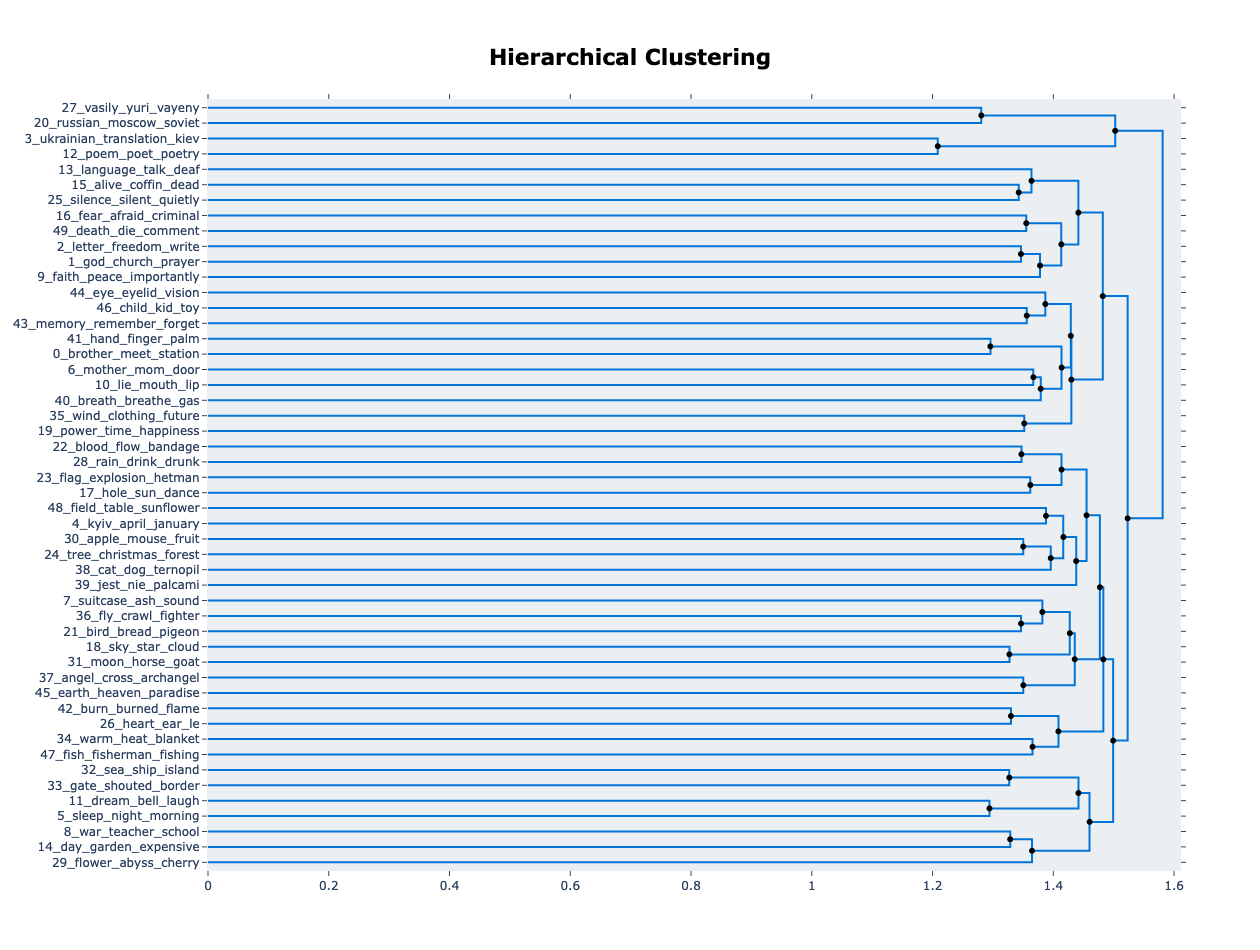

In [94]:
# Extract hierarchical topics and their representations
hierarchical_topics = topic_model.hierarchical_topics(doc_sample, topics)

# Visualize these representations
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)